# The 27 Element Tensor 

The purpose of this notebook is to address the following problem in the 3D simulation: The eigenvalue of the symmetric tensor are negative. 

I think that this might be associated with variance transport. 

At the tensor level, it implies that the symmetric tensor is composed of two parts - the local irreversible diffusion and the non-local transport of dispersion. 


\begin{equation} 
\mathbf{S} =\frac{1}{2}\frac{\partial}{\partial t}\overline{\xi^i \xi^j} + \frac{1}{2}\mathbf{U}. \nabla \overline{\xi^i \xi^j},
\end{equation}
where $\mathbf{K}= \mathbf{S}+\mathbf{A}$. 

We have the anticipation at that the first of these terms will be positive since locally particles usually disperse from each other in a homogeneous system. However, the second can be positive or negative. 

Since the second part of $\mathbf{S}$ depends on the mean flow, which is known, we could attempt to solve the inverse problem to estimate both : $(\overline{\xi^i \xi^j})_t$ and $(\overline{\xi^i \xi^j})_{x_i}$. This makes the problem go from estimating 6 elements of sym tensor to 18 elements. 

The flux is now represented as 

\begin{equation}
\overline{u_i c} = -[K_{ij}C_j + (J_{xj})_x u C_j + (J_{yj})_y v C_j + (J_{zj})_z wC_j]
\end{equation}

We can write this as a least squares problem, and solve for the 27 unknowns!!

In [1]:
import numpy as np
import xarray as xr
from funcs import *
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm

In [2]:
Lcoarse = 50e3

In [41]:
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')
diff_tensor_single = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
diff_tensor_withKPP = xr.open_dataset('./outputs_ncfiles/diff_tensor_with_diff_'+str(int(Lcoarse//1e3))+'km.nc')

list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [4]:
# Choose a location to do the analysis 
xloc= 1700e3
yloc = 1000e3
zloc =-300

In [5]:
def calc_tensor_vec(uc,vc,wc, cx,cy,cz): 
    
    bvec = np.concatenate((uc,vc,wc))
    
    grad = np.array([cx, cy, cz]).T
    
    E1vec = np.concatenate((grad, np.zeros_like(grad), np.zeros_like(grad)), axis=1)
    E2vec = np.concatenate((np.zeros_like(grad), grad, np.zeros_like(grad)), axis=1)
    E3vec = np.concatenate((np.zeros_like(grad), np.zeros_like(grad), grad), axis=1)
    
    Evec = np.concatenate((E1vec, E2vec, E3vec), axis=0)
    
    K = -pinv(Evec).dot(bvec)
    
    K = K.reshape((3,3))
    return K

(-900, 0)

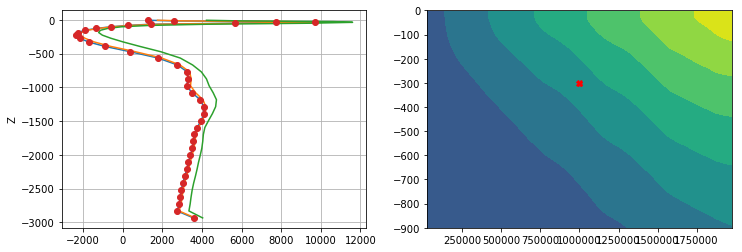

In [29]:
# A plot of a region where we see large, systematic negative eigenvalues 

# Where are we in location? 
X = T_coarse.XCcoarse
Y = T_coarse.YCcoarse
Z = T_coarse.Z

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(diff_tensor.eigvalsSTcorr.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(diff_tensor.eigvalsSTslow.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(diff_tensor.eigvalsSTfast.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(diff_tensor_withKPP.eigvalsST.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z,'o')
plt.grid()
plt.ylabel('Z')
# the different between with and without KPP is minor (order 0.002)

plt.subplot(122)
plt.contourf(Y, Z, T_coarse['T'].sel(XCcoarse=xloc, method='nearest'))
plt.plot(yloc, zloc, 'X', color='r')
plt.ylim([-900,0])

#### Check. 
That the estimate of the tensor using the vector form, and directly using the pinv gives the same result. 

In [10]:
def make_sym(A):
    S = np.zeros((3,3))
    S[0,0] = A[0]
    S[0,1] = A[1]
    S[0,2] = A[2]
    S[1,0] = A[1]
    S[1,1] = A[3]
    S[1,2] = A[4]
    S[2,0] = A[2]
    S[2,1] = A[4]
    S[2,2] = A[5]
    
    return S

In [11]:
# make sure the eigen values are arranged by magnitude (instead of the default arrangement)
def eigen(A):
    if ~(np.isnan(A).any() | np.isinf(A).any()):
        eigenValues, eigenVectors = eigh(A)
        idx = np.argsort(np.abs(eigenValues))
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        return (eigenValues, eigenVectors)
    else:
        return (np.nan, np.nan)

In [12]:
def calc_tensor_2vec_loc(uc,vc,wc, cx,cy,cz, U, V, W): 
    
    bvec = np.concatenate((uc,vc,wc))
    
    grad = np.array([cx, cy, cz]).T
    
    Zeros = np.zeros_like(cx)
    
    E1vec = np.array([cx,cy,cz, Zeros, Zeros, Zeros,Zeros, Zeros, Zeros,
                  U*cx, U*cy, U*cz, Zeros, Zeros, Zeros,
                  V*cx, V*cy, V*cz, Zeros, Zeros, Zeros,
                  W*cx, W*cy, W*cz, Zeros, Zeros, Zeros ])
    E2vec = np.array([Zeros, Zeros, Zeros, cx,cy,cz,  Zeros, Zeros, Zeros, 
                  Zeros, U*cx,  Zeros, U*cy, U*cz, Zeros, 
                  Zeros, V*cx,  Zeros, V*cy, V*cz, Zeros, 
                  Zeros, W*cx,  Zeros, W*cy, W*cz, Zeros])
    E3vec = np.array([Zeros, Zeros, Zeros, Zeros, Zeros, Zeros, cx,cy,cz, 
                  Zeros, Zeros, U*cx, Zeros, U*cy, U*cz, 
                  Zeros, Zeros, V*cx, Zeros, V*cy, V*cz, 
                  Zeros, Zeros, W*cx, Zeros, W*cy, W*cz, ])
    Evec = np.concatenate((E1vec, E2vec, E3vec), axis=1).T
    
        
    K = -pinv(Evec).dot(bvec)
    
    KL = K[0:9].reshape((3,3))
    
    Jx = K[9:15]
    Jy = K[15:21]
    Jz = K[21:27]
    
    KNL = np.array(U*make_sym(Jx) + V*make_sym(Jy) + W*make_sym(Jz))
    
    return  KL

In [13]:
def calc_tensor_2vec_nonloc(uc,vc,wc, cx,cy,cz, U, V, W): 
    
    bvec = np.concatenate((uc,vc,wc))
    
    grad = np.array([cx, cy, cz]).T
    
    Zeros = np.zeros_like(cx)
    
    E1vec = np.array([cx,cy,cz, Zeros, Zeros, Zeros,Zeros, Zeros, Zeros,
                  U*cx, U*cy, U*cz, Zeros, Zeros, Zeros,
                  V*cx, V*cy, V*cz, Zeros, Zeros, Zeros,
                  W*cx, W*cy, W*cz, Zeros, Zeros, Zeros ])
    E2vec = np.array([Zeros, Zeros, Zeros, cx,cy,cz,  Zeros, Zeros, Zeros, 
                  Zeros, U*cx,  Zeros, U*cy, U*cz, Zeros, 
                  Zeros, V*cx,  Zeros, V*cy, V*cz, Zeros, 
                  Zeros, W*cx,  Zeros, W*cy, W*cz, Zeros])
    E3vec = np.array([Zeros, Zeros, Zeros, Zeros, Zeros, Zeros, cx,cy,cz, 
                  Zeros, Zeros, U*cx, Zeros, U*cy, U*cz, 
                  Zeros, Zeros, V*cx, Zeros, V*cy, V*cz, 
                  Zeros, Zeros, W*cx, Zeros, W*cy, W*cz, ])
    Evec = np.concatenate((E1vec, E2vec, E3vec), axis=1).T
    
        
    K = -pinv(Evec).dot(bvec)
    
    KL = K[0:9].reshape((3,3))
    
    Jx = K[9:15]
    Jy = K[15:21]
    Jz = K[21:27]
    
    KNL = np.array(U*make_sym(Jx) + V*make_sym(Jy) + W*make_sym(Jz))
    
    return  KNL

In [14]:
KL =xr.apply_ufunc(calc_tensor_2vec_loc, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       Vels_coarse.U,
                       Vels_coarse.V,
                       Vels_coarse.W,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], 
                                        ['tracer_num'], ['tracer_num'], ['tracer_num'], [], [],[]],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

KNL =xr.apply_ufunc(calc_tensor_2vec_nonloc, 
                       UpCp.sel(tracer_num=slice(2,20,2)),
                       VpCp.sel(tracer_num=slice(2,20,2)),
                       WpCp.sel(tracer_num=slice(2,20,2)),
                       dCdx.sel(tracer_num=slice(2,20,2)),
                       dCdy.sel(tracer_num=slice(2,20,2)),
                       dCdz.sel(tracer_num=slice(2,20,2)),
                       Vels_coarse.U,
                       Vels_coarse.V,
                       Vels_coarse.W,
                       input_core_dims=[['tracer_num'], ['tracer_num'], ['tracer_num'], 
                                        ['tracer_num'], ['tracer_num'], ['tracer_num'], [], [],[]],
                       vectorize=True, output_core_dims=[['i','j']], dask='parallelized', 
                       output_dtypes=['float32'], output_sizes={'i':3,'j':3})

In [15]:
KL_T = KL.transpose('Z','YCcoarse','XCcoarse','j','i')

STL = 0.5*(KL.data + KL_T.data)
ATL = 0.5*(KL.data - KL_T.data)

STL = xr.DataArray(STL, coords=KL.coords, dims=KL.dims)
ATL = xr.DataArray(ATL, coords=KL.coords, dims=KL.dims)

In [16]:
KNL_T = KNL.transpose('Z','YCcoarse','XCcoarse','j','i')

STNL = 0.5*(KNL.data + KNL_T.data)
ATNL = 0.5*(KNL.data - KNL_T.data)

STNL = xr.DataArray(STNL, coords=KNL.coords, dims=KNL.dims)
ATNL = xr.DataArray(ATNL, coords=KNL.coords, dims=KNL.dims)

In [18]:
# calculate the eigenvalues and eigenvectors of symmetric part
eigvalsSTL, eigvecsSTL = xr.apply_ufunc(eigen, STL, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])

eigvalsSTNL, eigvecsSTNL = xr.apply_ufunc(eigen, STNL, input_core_dims=[['i','j']],
                                    vectorize=True, output_core_dims=[['ii'], ['k','ii']])


In [30]:
diff_tensor = xr.Dataset()
diff_tensor['KL'] = KL
diff_tensor['KNL'] = KNL

diff_tensor['STL'] = STL
diff_tensor['STNL'] = STNL
diff_tensor['ATL'] = ATL

diff_tensor['eigvalsSTL'] = np.real(eigvalsSTL)
diff_tensor['eigvecsSTL'] = eigvecsSTL

diff_tensor['eigvalsSTNL'] = np.real(eigvalsSTNL)
diff_tensor['eigvecsSTNL'] = eigvecsSTNL

In [24]:
diff_tensor.to_netcdf('./outputs_ncfiles/diff_tensor_L-NL_'+str(int(Lcoarse//1e3))+'km.nc')

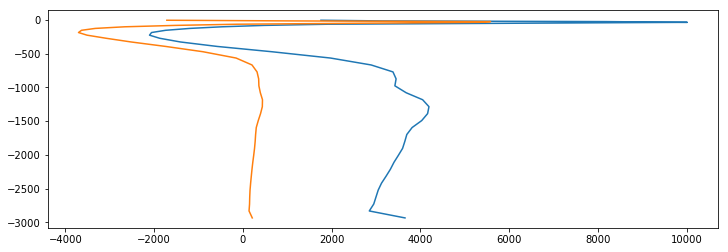

In [26]:
plt.figure(figsize=(12,4))

plt.plot(diff_tensor.eigvalsSTL.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
plt.plot(100*diff_tensor.eigvalsSTNL.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)
#plt.plot(diff_tensor.eigvalsSTfast.sel(XCcoarse=xloc, YCcoarse=yloc, method='nearest').isel(ii=1), Z)


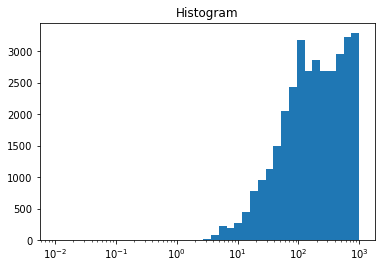

In [37]:
[_,_,_]=(diff_tensor.eigvalsSTL / diff_tensor.eigvalsSTNL).isel(ii=2).plot.hist(bins = np.logspace(-2,3,40))
plt.xscale('log')

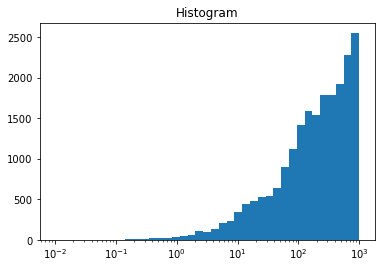

In [38]:
[_,_,_]=(diff_tensor.eigvalsSTL / diff_tensor.eigvalsSTNL).isel(ii=1).plot.hist(bins = np.logspace(-2,3,40))
plt.xscale('log')

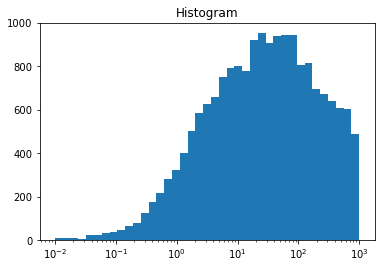

In [39]:
[_,_,_]=(diff_tensor.eigvalsSTL / diff_tensor.eigvalsSTNL).isel(ii=0).plot.hist(bins = np.logspace(-2,3,40))
plt.xscale('log')

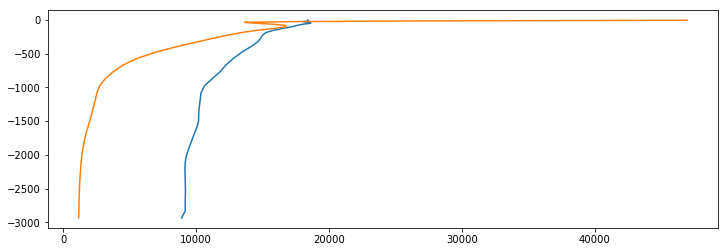

In [27]:
bins = np.linspace(-1e4,3e4,41)
[_,_,_]=diff_tensor_single.eigvalsSTL.isel(ii=1).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{across}$')

[_,_,_]=diff_tensor.eigvalsSTL.isel(ii=2).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{along}$')
[_,_,_]=diff_tensor.eigvalsSTL.isel(ii=1).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{across}$')
plt.legend()
plt.title('')
plt.xlabel('$m^2/s$')
plt.ylabel('PDF')
plt.grid()
#plt.savefig('figKpdf.pdf', dpi=200,bbox_inches='tight')

In [42]:
diff_tensor_single

<xarray.Dataset>
Dimensions:        (XCcoarse: 40, YCcoarse: 40, Z: 40, i: 3, ii: 3, j: 3, k: 3)
Coordinates:
  * Z              (Z) float32 -5.0 -15.0 -25.0 ... -2727.5 -2830.5 -2933.5
  * YCcoarse       (YCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
  * XCcoarse       (XCcoarse) float32 25000.0 75000.0 ... 1925000.0 1975000.0
    hFacCcoarse    (Z, YCcoarse, XCcoarse) float32 ...
    PHrefC         (Z) float32 ...
    drF            (Z) float32 ...
Dimensions without coordinates: i, ii, j, k
Data variables:
    Kfast          (Z, YCcoarse, XCcoarse, i, j) float32 ...
    Kslow          (Z, YCcoarse, XCcoarse, i, j) float32 ...
    Kcorr          (Z, YCcoarse, XCcoarse, i, j) float32 ...
    STcorr         (Z, YCcoarse, XCcoarse, i, j) float32 ...
    ATcorr         (Z, YCcoarse, XCcoarse, i, j) float32 ...
    eigvalsSTcorr  (Z, YCcoarse, XCcoarse, ii) float32 ...
    eigvecsSTcorr  (Z, YCcoarse, XCcoarse, k, ii) float32 ...
    STslow         (Z, YCcoarse, XCcoarse, i, j

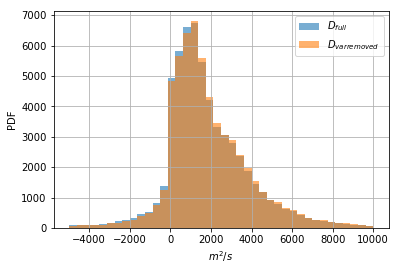

In [52]:
bins = np.linspace(-0.5e4,1e4,41)
[_,_,_]=diff_tensor_single.eigvalsSTcorr.isel(ii=1).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{full}$')

#[_,_,_]=diff_tensor.eigvalsSTL.isel(ii=2).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{along}$')
[_,_,_]=diff_tensor.eigvalsSTL.isel(ii=1).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{var removed}$')
plt.legend()
plt.title('')
plt.xlabel('$m^2/s$')
plt.ylabel('PDF')
plt.grid()
#plt.savefig('figKpdf.pdf', dpi=200,bbox_inches='tight')

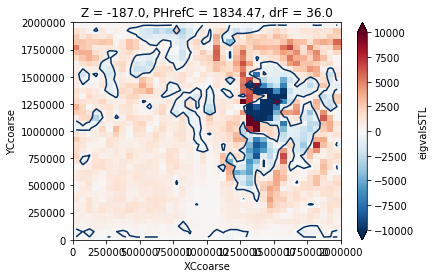

In [54]:
diff_tensor.eigvalsSTL.sel(Z=-200, method='nearest').isel(ii=1).plot(vmin=-1e4)
diff_tensor.eigvalsSTL.sel(Z=-200, method='nearest').isel(ii=1).plot.contour(levels=[0])

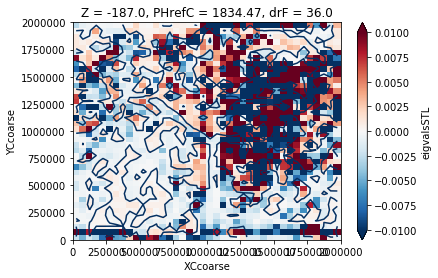

In [55]:
diff_tensor.eigvalsSTL.sel(Z=-200, method='nearest').isel(ii=0).plot(vmin=-1e-2)
diff_tensor.eigvalsSTL.sel(Z=-200, method='nearest').isel(ii=0).plot.contour(levels=[0])

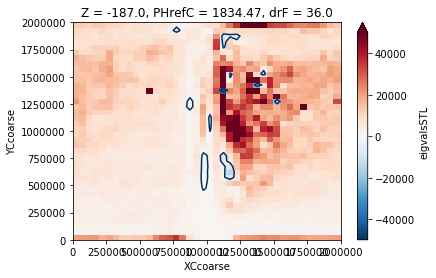

In [58]:
diff_tensor.eigvalsSTL.sel(Z=-200, method='nearest').isel(ii=2).plot(vmin=-5e4)
diff_tensor.eigvalsSTL.sel(Z=-200, method='nearest').isel(ii=2).plot.contour(levels=[0])